# immporting necessary libraries

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation plots
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt


# Loading Data

In [141]:
df = pd.read_csv('ADANIPORTS.csv')
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.00,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.00,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.00,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.00,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.00,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,2021-04-26,ADANIPORTS,EQ,725.35,733.00,739.65,728.90,729.2,730.75,733.25,9390549,6.885658e+14,116457.0,838079,0.0892
3318,2021-04-27,ADANIPORTS,EQ,730.75,735.00,757.50,727.35,748.6,749.15,747.67,20573107,1.538191e+15,236896.0,1779639,0.0865
3319,2021-04-28,ADANIPORTS,EQ,749.15,755.00,760.00,741.10,743.4,746.25,751.02,11156977,8.379106e+14,130847.0,1342353,0.1203
3320,2021-04-29,ADANIPORTS,EQ,746.25,753.20,765.85,743.40,746.4,746.75,753.06,13851910,1.043139e+15,153293.0,1304895,0.0942


In [156]:
df.isnull().sum()

Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                866
Deliverable Volume      0
%Deliverble             0
dtype: int64

In [157]:
df.duplicated().sum()

0

In [146]:
df['Date'].dtype

dtype('<M8[ns]')

In [147]:
df['Date']  = pd.to_datetime(df['Date'])

In [ ]:
df.set_index('Date',inplace = True) 

In [160]:
df.head(3)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2007-11-27,MUNDRAPORT,EQ,440.0,770.0,1050.00,770.0,959.0,962.9,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
2007-11-28,MUNDRAPORT,EQ,962.9,984.0,990.00,874.0,885.0,893.9,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2007-11-29,MUNDRAPORT,EQ,893.9,909.0,914.75,841.0,887.0,884.2,888.09,5124121,4.550658e+14,NaN,1069678,0.2088


Text(0, 0.5, 'close price')

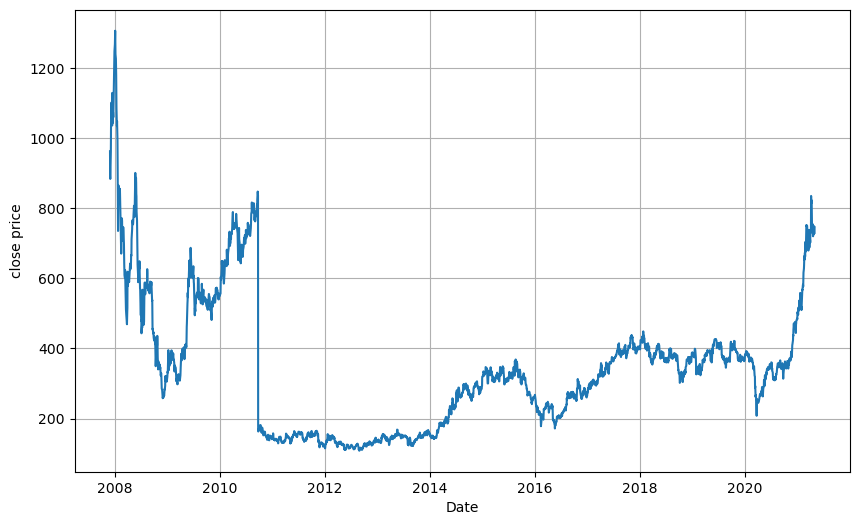

In [161]:
plt.figure(figsize=(10,6))
plt.plot(df.index,df['Close'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('close price')

In [168]:
dff = df['Close']

In [167]:
dff

Date
2007-11-27    962.90
2007-11-28    893.90
2007-11-29    884.20
2007-11-30    921.55
2007-12-03    969.30
               ...  
2021-04-26    730.75
2021-04-27    749.15
2021-04-28    746.25
2021-04-29    746.75
2021-04-30    730.05
Name: Close, Length: 3322, dtype: float64

<Axes: xlabel='Date'>

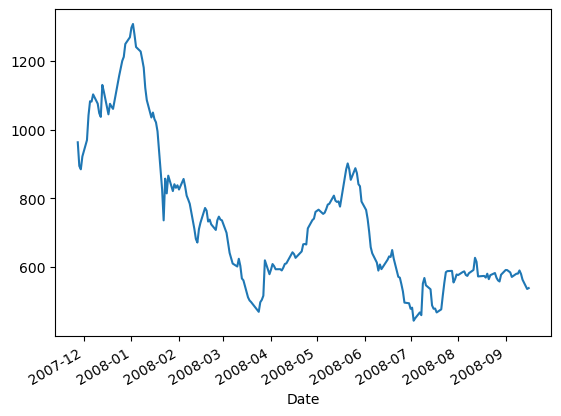

In [170]:
dff[:200].plot() ## zooming

# Descriptive Statistics

In [120]:
dff.describe(include='all')

,Close
count,3322.000000
mean,344.201626
std,193.045886
min,108.000000
25%,164.312500
50%,324.700000
75%,400.912500
max,1307.450000


In [121]:
dff

,Close
Date,
2007-11-27,962.90
2007-11-28,893.90
2007-11-29,884.20
2007-11-30,921.55
2007-12-03,969.30
...,...
2021-04-26,730.75
2021-04-27,749.15
2021-04-28,746.25


# seasonal decompose

In [171]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [172]:
additive_decompose = seasonal_decompose(dff,model='multiplicative',period=252)
trend = additive_decompose.trend
seasonality = additive_decompose.seasonal
resid = additive_decompose.resid

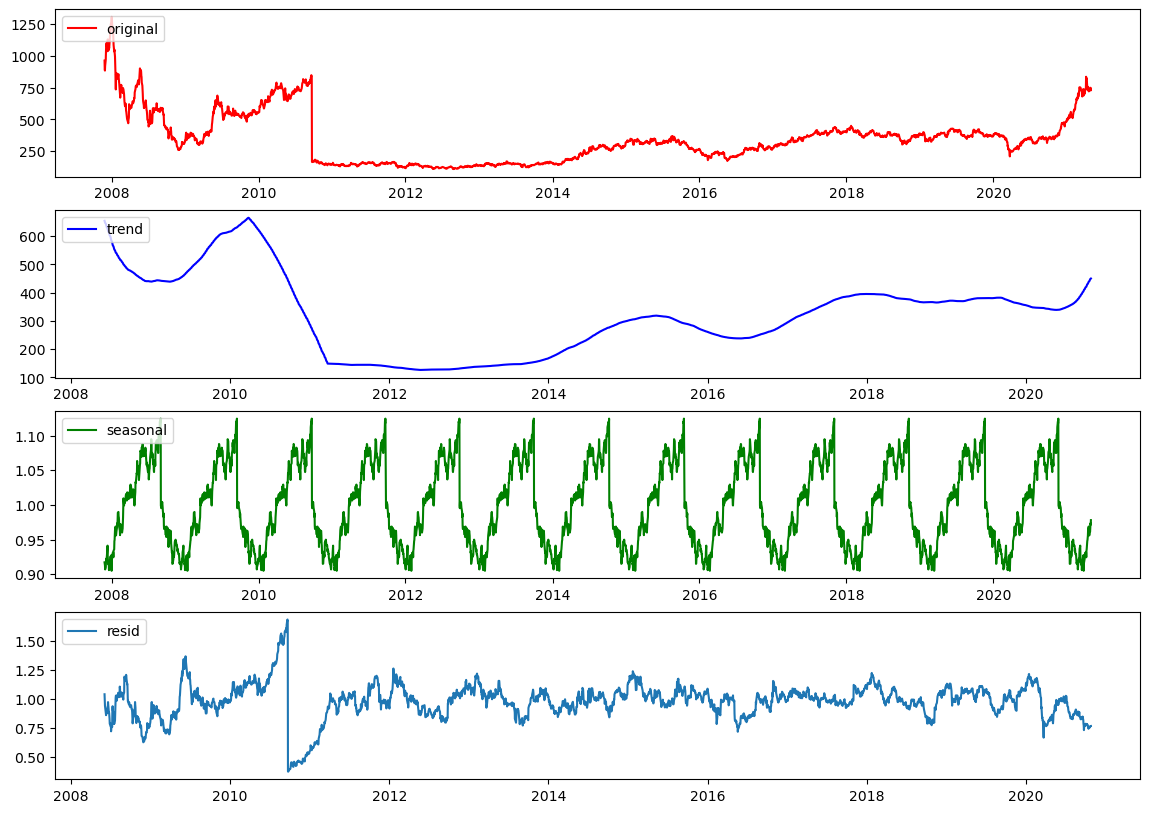

In [173]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dff,label='original',color='r')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='trend',color='b')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality,label='seasonal',color='g')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(resid,label='resid')
plt.legend(loc='upper left')

# smoothing method

# Moving avg

In [174]:
windowsize=20
df['SMA'] = df['Close'].rolling(window=windowsize).mean()

#calculated weighted moving average
weights = np.arange(1,windowsize+1)
df['WMA'] = df['Close'].rolling(windowsize).apply(lambda prices : np.dot(prices,weights)/weights.sum(),raw=True)

#calculate Exponential Moving AVG
df['EMA'] = df['Close'].ewm(span=windowsize).mean()

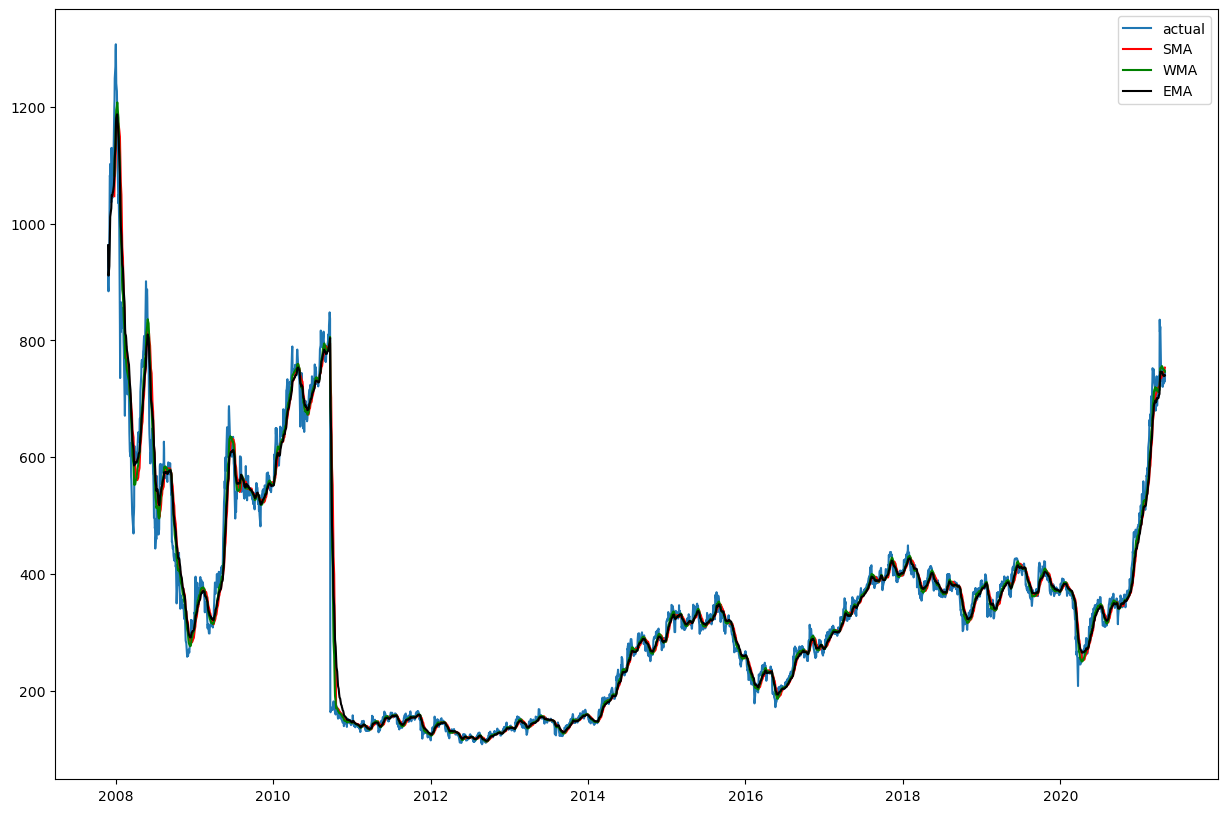

In [175]:
plt.figure(figsize=(15,10))
plt.plot(df['Close'],label='actual')
plt.plot(df['SMA'],label='SMA',color='r')
plt.plot(df['WMA'],label='WMA',color='green')
plt.plot(df['EMA'],label='EMA',color='black')


plt.legend()
plt.show()


# ADF TEST

# adf test Used to Check  the data is stationary or not)

In [176]:
from statsmodels.tsa.stattools import adfuller

In [177]:
adf_test = adfuller(dff)
print('ADF Test Result:')
print(f'ADF statistic : {round(adf_test[0],3)}')
print(f'p-value : {round(adf_test[1],3)}')
print('critical value')
for key,value in adf_test[4].items():
    print(f'{key}:{round(value,3)}')

ADF Test Result:
ADF statistic : -3.473
p-value : 0.009
critical value
1%:-3.432
5%:-2.862
10%:-2.567


In [178]:
#interpret the results
if adf_test[1] <= 0.05:
  print("Time Series Data is Stationary")
else:
  print("Time Series Data is Non-Stationary, Differencing is required")

Time Series Data is Stationary


Text(0.5, 1.0, 'PACF Plot of APPLe close ')

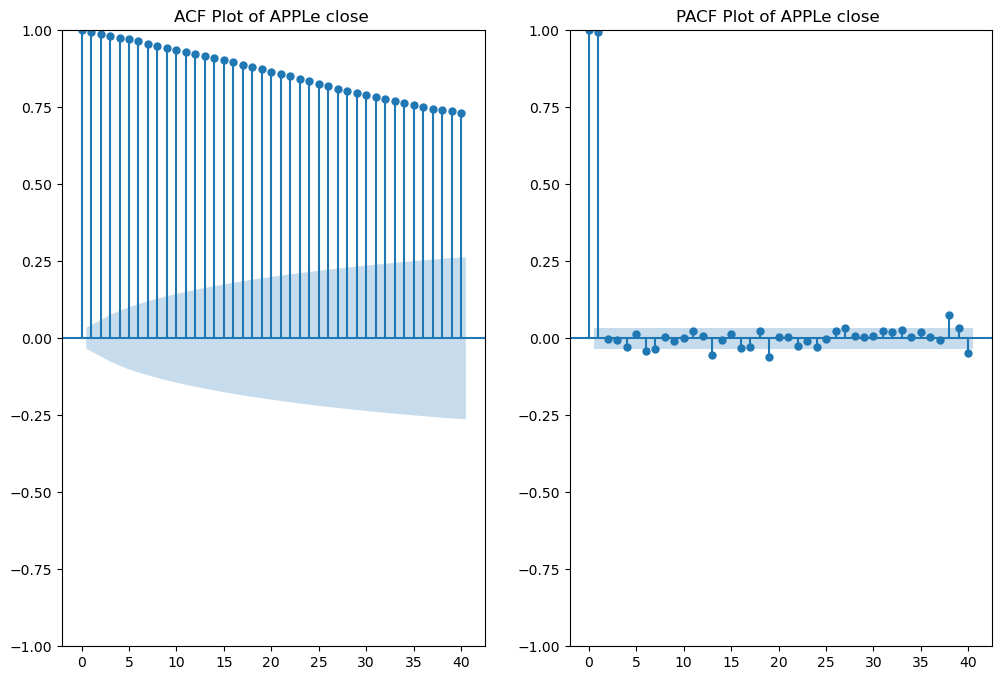

In [182]:
plt.figure(figsize=(12,8))
#acf plot
plt.subplot(1,2,1)
plot_acf(dff.dropna(),ax=plt.gca(),lags=40)
plt.title('ACF Plot of APPLe close ')

#pacf plot
plt.subplot(1,2,2)
plot_pacf(dff.dropna(),ax=plt.gca(),lags=40,method='ywm')
plt.title('PACF Plot of APPLe close ')

In [183]:
dff

Date
2007-11-27    962.90
2007-11-28    893.90
2007-11-29    884.20
2007-11-30    921.55
2007-12-03    969.30
               ...  
2021-04-26    730.75
2021-04-27    749.15
2021-04-28    746.25
2021-04-29    746.75
2021-04-30    730.05
Name: Close, Length: 3322, dtype: float64

In [184]:
ts = df['Close']

# Grid search

In [185]:

# Load your time series

# Function to find best (p,d,q)
def find_best_pdq(ts, p_range, d_range, q_range):
    best_score = float("inf")  # sabse acchi AIC store karega
    best_order = None          # best (p,d,q) yahan store hoga
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(ts, order=(p,d,q)).fit()  # model fit karo
                    aic = model.aic  # AIC nikalo

                    if aic < best_score:
                        best_score = aic
                        best_order = (p,d,q)
                    
                    print(f"Trying ARIMA({p},{d},{q}) AIC={aic:.2f}")
                except:
                    continue  # agar error aaye to skip

    print(f"\n Best ARIMA(p,d,q): {best_order} with AIC={best_score:.2f}")
    return best_order

# Call the function with desired ranges
best_order = find_best_pdq(ts, range(0, 4), range(0, 3), range(0, 4))


Trying ARIMA(0,0,0) AIC=44397.32
Trying ARIMA(0,0,1) AIC=40176.43
Trying ARIMA(0,0,2) AIC=37043.25
Trying ARIMA(0,0,3) AIC=34931.09
Trying ARIMA(0,1,0) AIC=28088.96
Trying ARIMA(0,1,1) AIC=28085.81
Trying ARIMA(0,1,2) AIC=28087.48
Trying ARIMA(0,1,3) AIC=28088.26
Trying ARIMA(0,2,0) AIC=30238.98
Trying ARIMA(0,2,1) AIC=28091.00
Trying ARIMA(0,2,2) AIC=28087.87
Trying ARIMA(0,2,3) AIC=28089.54
Trying ARIMA(1,0,0) AIC=28104.94
Trying ARIMA(1,0,1) AIC=28101.40
Trying ARIMA(1,0,2) AIC=28102.95
Trying ARIMA(1,0,3) AIC=28103.50
Trying ARIMA(1,1,0) AIC=28085.72
Trying ARIMA(1,1,1) AIC=28087.39
Trying ARIMA(1,1,2) AIC=28088.20
Trying ARIMA(1,1,3) AIC=28085.86
Trying ARIMA(1,2,0) AIC=29353.12
Trying ARIMA(1,2,1) AIC=28087.77
Trying ARIMA(1,2,2) AIC=28088.93
Trying ARIMA(1,2,3) AIC=28090.25
Trying ARIMA(2,0,0) AIC=28101.28
Trying ARIMA(2,0,1) AIC=28102.82
Trying ARIMA(2,0,2) AIC=28103.86
Trying ARIMA(2,0,3) AIC=28101.08
Trying ARIMA(2,1,0) AIC=28087.42
Trying ARIMA(2,1,1) AIC=28089.36
Trying ARI

# TIME SERIES  FORECASTING MODELS

# MA

In [186]:
from statsmodels.tsa.arima.model import ARIMA

In [187]:
df.head(2)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,SMA,WMA,EMA
Date,,,,,,,,,,,,,,,,,
2007-11-27,MUNDRAPORT,EQ,440.0,770.0,1050.0,770.0,959.0,962.9,984.72,27294366,2.687719e+15,NaN,9859619,0.3612,NaN,NaN,962.900
2007-11-28,MUNDRAPORT,EQ,962.9,984.0,990.0,874.0,885.0,893.9,941.38,4581338,4.312765e+14,NaN,1453278,0.3172,NaN,NaN,926.675


In [194]:
#train_size=int(len(dff)*0.8)
#train_data,test_data=dff.iloc[:train_size],dff.iloc[train_size:]
close_price = dff.diff().dropna()


In [195]:
train_data ,  test_data = close_price[:-30] ,close_price[-30:]

In [196]:
train_data.shape,test_data.shape

((3291,), (30,))

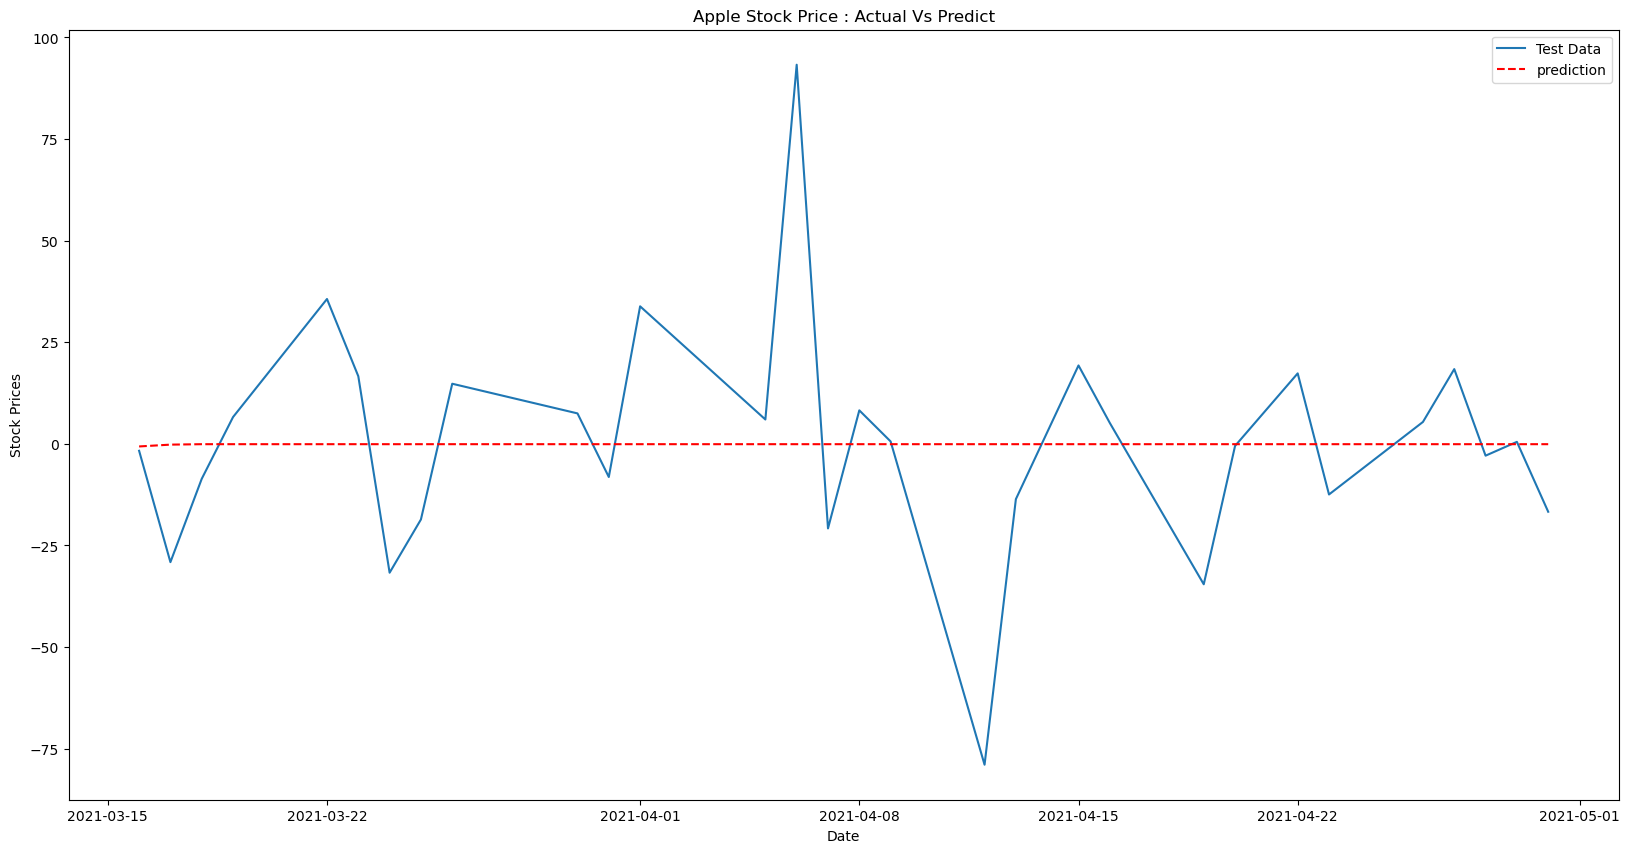

RMSE Score: 28.11


In [197]:
#fit the  MA model(MA) to the training data
model = ARIMA(train_data,order=(0, 0, 2))
model_fit = model.fit()

#make prediction on test_data
prediction = model_fit.predict(start=len(train_data),end=len(train_data) + len(test_data)-1,dynamic=False)

#plot the  actual vs predicted
plt.figure(figsize=(20,10))
plt.plot(test_data.index , test_data , label='Test Data')
plt.plot(test_data.index , prediction , label='prediction',color='r',linestyle='--')
plt.title('Apple Stock Price : Actual Vs Predict')
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

#evaluating model using rmse score
rmse = round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# ARMA

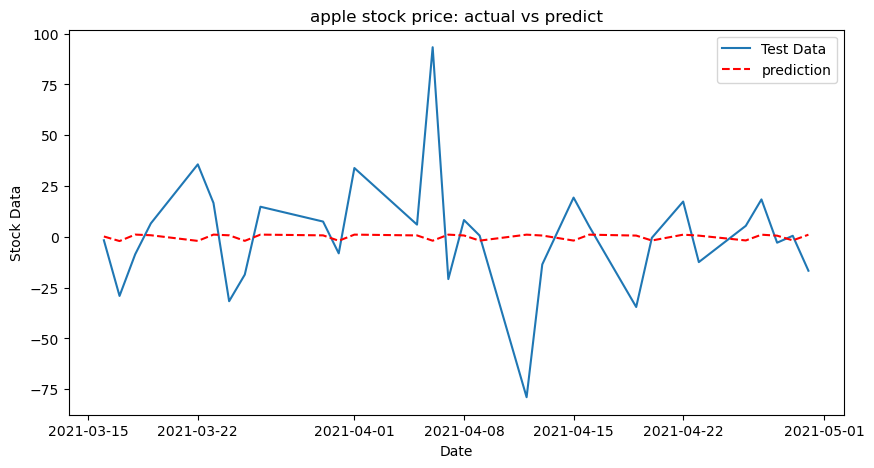

RMSE Score: 28.44


In [199]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data,order=(3,0,2))
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=False)

#plot the actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,prediction,color='r',linestyle='--',label='prediction')
plt.title('apple stock price: actual vs predict')
plt.xlabel('Date')
plt.ylabel('Stock Data')
plt.legend()
plt.show()

rmse =  round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# ARIMA

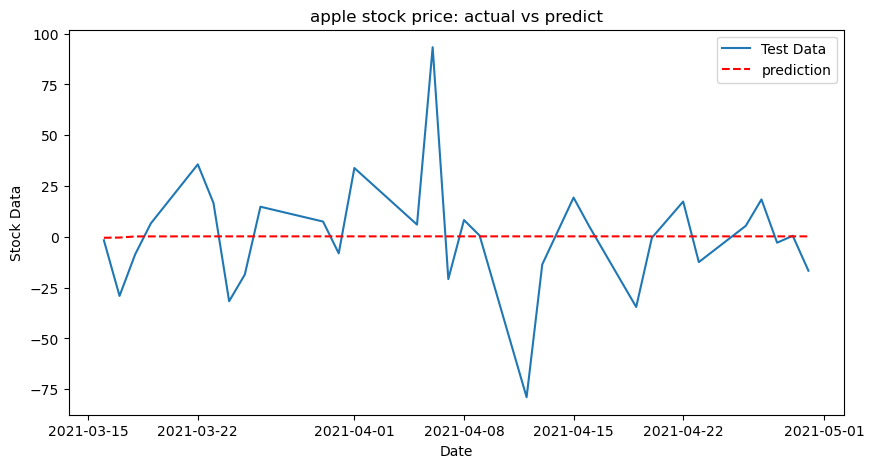

RMSE Score: 28.09


In [200]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data,order=(3,1,2))
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=False)

#plot the actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,prediction,color='r',linestyle='--',label='prediction')
plt.title('apple stock price: actual vs predict')
plt.xlabel('Date')
plt.ylabel('Stock Data')
plt.legend()
plt.show()

rmse =  round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# SARIMA

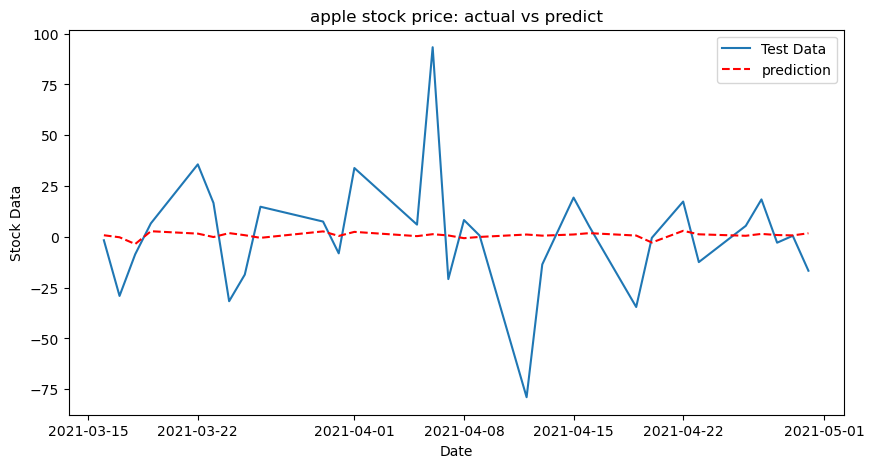

RMSE Score: 27.95


In [201]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p,d,q = 3,1,2
P,D,Q,s = 1,1,1,20
model = SARIMAX(train_data,order=(p,d,q),seasonal_order = (P,D,Q,s))
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=False)

#plot the actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,prediction,color='r',linestyle='--',label='prediction')
plt.title('apple stock price: actual vs predict')
plt.xlabel('Date')
plt.ylabel('Stock Data')
plt.legend()
plt.show()

rmse =  round(np.sqrt(mean_squared_error(test_data,prediction)),2)
print('RMSE Score:',rmse)

# USING LSTM

In [103]:
# Normalize Close price
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

In [104]:
len(scaled_close)

3322

In [105]:
# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(0,3322 - 60):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [106]:
SEQ_LEN = 60
X, y = create_sequences(scaled_close, SEQ_LEN)

In [107]:
y

array([[0.52490725],
       [0.51356872],
       [0.49993747],
       ...,
       [0.53211889],
       [0.53253575],
       [0.5186127 ]])

In [108]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [109]:
X_train.shape,

((2609, 60, 1),)

In [110]:
# Build model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])
model.compile(optimizer=Adam(0.01), loss='mse',metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


C:\Users\khans\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 2.7252e-04 - loss: 0.0040 - val_accuracy: 0.0000e+00 - val_loss: 2.1276e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 6.3408e-04 - loss: 3.9490e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.1915e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 5.1092e-04 - loss: 4.3730e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.0451e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 1.5389e-04 - loss: 1.5874e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.0433e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 9.2359e-06 - loss: 2.2162e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.1123e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 1.2769e-04 - loss: 1.0928e-04 - val_accuracy: 0.0000e+00 - val_loss: 4.8657e-04
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 2.8183e-05 - loss: 4.2888e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.0972e-04
Epoch 8/20
82/

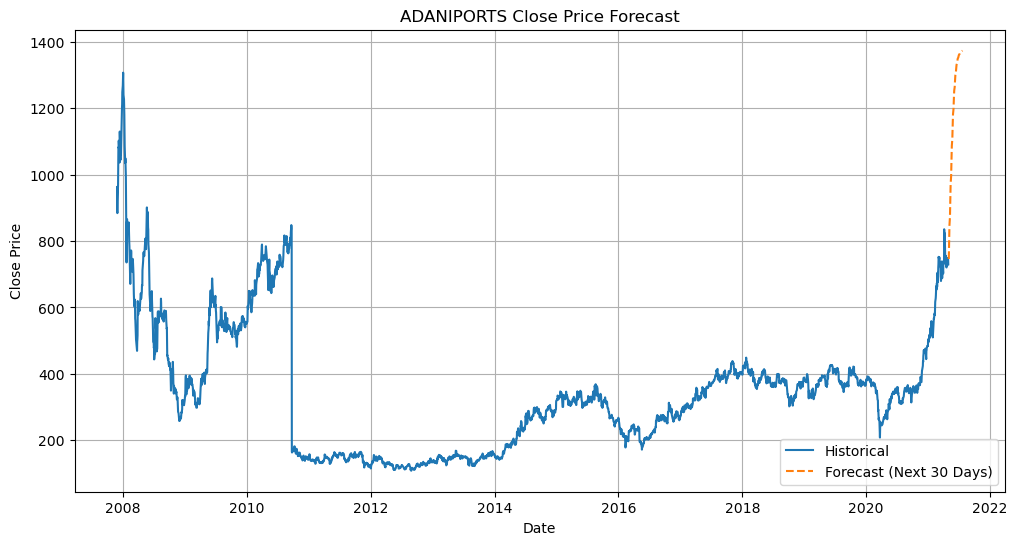

In [112]:
# Forecast next 30 days
last_seq = scaled_close[-SEQ_LEN:]
forecast = []
for _ in range(60):
    pred = model.predict(last_seq.reshape(1, SEQ_LEN, 1),verbose=0)[0][0]
    forecast.append(pred)
    last_seq = np.append(last_seq[1:], [[pred]], axis=0)

forecast_prices = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot
forecast_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=60, freq='B')
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Historical')
plt.plot(forecast_dates, forecast_prices, label='Forecast (Next 30 Days)', linestyle='--')
plt.title('ADANIPORTS Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()